# Project Name: Spotify 2017-2021 Daily Global Top 200 Analysis
**Project Scope:** Exploring Spotify 2017-2021 Daily Global Top 200 Data to Unearth Trends, Insights, and Business Value.

**Data Source:** https://www.kaggle.com/c0lydxmas/spotify-top-200-daily-global-2017-2021

**By:** Krishan Deo

**Date:** May 23rd, 2022

The following cells outline the final Model Training and Evaluation sections of the project. The 2017, 2018, 2019, 2020, and 2021 datasets were used to train and evaluate 5 Binary Random Forest Classifiers and 5 Binary Neural Network Perceptron Classifiers. There is also a demonstration of the effectiveness of Hyperparameter Tuning. Finally, the insights and takeaways from this project are summarized using Feature Importances and Reflective Learnings.

* Note: the chosen performance metric was "Area Under the ROC Curve", and the threshold for acceptable performance was set at 80% AUC as per common online community consensus (ex: https://www.sciencedirect.com/science/article/pii/S1556086415306043#:~:text=In%20general%2C%20an%20AUC%20of,than%200.9%20is%20considered%20outstanding.)

* From article above: "...In general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, **0.8 to 0.9 is considered excellent**, and more than 0.9 is considered outstanding..."

### Initializing Local Spark Environment (IBM Cloud Deprecated Python 3.7)
* Spark Environment Intialized

In [1]:
# Local Spark Environment

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')

!pip install pyspark==2.4.5

try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')
    
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

spark.conf.set("spark.debug.maxToStringFields","true")

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 217.8 MB 11 kB/s s eta 0:00:01��█▎            | 130.9 MB 44.2 MB/s eta 0:00:02��███████████▌| 214.4 MB 48.4 MB/s eta 0:00:01
     |████████████████████████████████| 197 kB 40.3 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257928 sha256=8ee02c1ce99f50941be4c3f6137c31c401587032b03702be8b8c47b350d116d4
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/01/c0/03/1c241c9c482b647d4d99412a98a5c7f87472728ad41ae55e1e
Successfully built pyspark


22/04/05 00:26:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Object Store Access Credentials
* Credentials Removed for Privacy and Security

In [2]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_ffa959d2c80941dba05e8ff594f32acd = ibm_boto3.client(service_name='',
    ibm_api_key_id='',
    ibm_auth_endpoint="",
    config=Config(signature_version=''),
    endpoint_url='')

### Defining, Training, and Evaluating Random Forest Models for 2017, 2018, 2019, 2020, 2021 Datasets
The following section details the training and evaluation of 5 different Random Forest models - one each for the years 2017, 2018, 2019, 2020, and 2021. A 70/30 Train-Test split was used for these models. The performance results of these models using AUC are below. As can be seen, there is no overfitting. Finally, for each model, the feature importances were extracted to inform actionable insights and recommendations, and also to guide future improvements to the models via feature selection. 

**2017 Training Set:** 86.1%
<br>**2017 Test Set:** 85.2%
<br>**2018 Training Set:** 84.3%
<br>**2018 Test Set:** 83.4%
<br>**2019 Training Set:** 83.9%
<br>**2019 Test Set:** 82.5%
<br>**2020 Training Set:** 81.7%
<br>**2020 Test Set:** 80.4%
<br>**2021 Training Set:** 84.8%
<br>**2021 Test Set:** 83.5%

In [ ]:
# RF 70/30 - Model and Pipeline Definitions

# Imports

from pyspark.ml.feature import StringIndexer, VectorIndexer, MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.classification import LinearSVC, RandomForestClassifier
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Label Choice

labelchoice = 'binary_performance_bin'

# Define Evaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Pipeline Definitions

indexer = StringIndexer(inputCol=labelchoice, outputCol="label", stringOrderType="frequencyDesc")

indexer1 = StringIndexer(inputCol='key', outputCol="key_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer2 = StringIndexer(inputCol='time_signature', outputCol="timesig_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer3 = StringIndexer(inputCol='artistname', outputCol="artistname_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer4 = StringIndexer(inputCol='albumtype', outputCol="albumtype_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer6 = StringIndexer(inputCol='featuredartist', outputCol="featuredartist_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer7 = StringIndexer(inputCol='featuredartist2', outputCol="featuredartist2_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer8 = StringIndexer(inputCol='featuredartist3', outputCol="featuredartist3_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer9 = StringIndexer(inputCol='primary_genre', outputCol="primary_genre_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer10 = StringIndexer(inputCol='secondary_genre', outputCol="secondary_genre_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer11 = StringIndexer(inputCol='genre3', outputCol="genre3_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer12 = StringIndexer(inputCol='genre4', outputCol="genre4_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer13 = StringIndexer(inputCol='genre5', outputCol="genre5_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer14 = StringIndexer(inputCol='genre6', outputCol="genre6_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer15 = StringIndexer(inputCol='genre7', outputCol="genre7_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer16 = StringIndexer(inputCol='genre8', outputCol="genre8_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer17 = StringIndexer(inputCol='genre9', outputCol="genre9_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer18 = StringIndexer(inputCol='genre10', outputCol="genre10_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer19 = StringIndexer(inputCol='genre11', outputCol="genre11_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer20 = StringIndexer(inputCol='genre12', outputCol="genre12_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')

vectAssem1 = VectorAssembler(inputCols=['tempo'], outputCol="tempoassem")
vectAssem2 = VectorAssembler(inputCols=['duration_ms'], outputCol="durationassem")

normalizer1 = MinMaxScaler(inputCol="tempoassem", outputCol="scaled_tempo")

normalizer2 = MinMaxScaler(inputCol="durationassem", outputCol="scaled_duration")

finalVectorAssembler = VectorAssembler(inputCols=['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','scaled_tempo','scaled_duration','explicit','has_feature','multigenre','key_indexed','timesig_indexed','artistname_indexed','albumtype_indexed','featuredartist_indexed','featuredartist2_indexed','featuredartist3_indexed',"primary_genre_indexed","secondary_genre_indexed","genre3_indexed","genre4_indexed","genre5_indexed","genre6_indexed","genre7_indexed","genre8_indexed","genre9_indexed","genre10_indexed","genre11_indexed","genre12_indexed"], outputCol="features")

# Define Random Forest

rf1 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=400, maxDepth=8,maxBins=1000)
rf2 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=400, maxDepth=8,maxBins=1000)
rf3 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=400, maxDepth=8,maxBins=1000)
rf4 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=400, maxDepth=8,maxBins=1000)
rf5 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=400, maxDepth=8,maxBins=1000)

# Define Pipeline

pipeline1 = Pipeline(stages=[indexer,indexer1,indexer2,indexer3,indexer4,indexer6,indexer7,indexer8,indexer9,indexer10,indexer11,indexer12,indexer13,indexer14,indexer15,indexer16,indexer17,indexer18,indexer19,indexer20,vectAssem1,vectAssem2,normalizer1,normalizer2,finalVectorAssembler,rf1])
pipeline2 = Pipeline(stages=[indexer,indexer1,indexer2,indexer3,indexer4,indexer6,indexer7,indexer8,indexer9,indexer10,indexer11,indexer12,indexer13,indexer14,indexer15,indexer16,indexer17,indexer18,indexer19,indexer20,vectAssem1,vectAssem2,normalizer1,normalizer2,finalVectorAssembler,rf2])
pipeline3 = Pipeline(stages=[indexer,indexer1,indexer2,indexer3,indexer4,indexer6,indexer7,indexer8,indexer9,indexer10,indexer11,indexer12,indexer13,indexer14,indexer15,indexer16,indexer17,indexer18,indexer19,indexer20,vectAssem1,vectAssem2,normalizer1,normalizer2,finalVectorAssembler,rf3])
pipeline4 = Pipeline(stages=[indexer,indexer1,indexer2,indexer3,indexer4,indexer6,indexer7,indexer8,indexer9,indexer10,indexer11,indexer12,indexer13,indexer14,indexer15,indexer16,indexer17,indexer18,indexer19,indexer20,vectAssem1,vectAssem2,normalizer1,normalizer2,finalVectorAssembler,rf4])
pipeline5 = Pipeline(stages=[indexer,indexer1,indexer2,indexer3,indexer4,indexer6,indexer7,indexer8,indexer9,indexer10,indexer11,indexer12,indexer13,indexer14,indexer15,indexer16,indexer17,indexer18,indexer19,indexer20,vectAssem1,vectAssem2,normalizer1,normalizer2,finalVectorAssembler,rf5])


#### Load 2017 Data

In [4]:
body = client_ffa959d2c80941dba05e8ff594f32acd.get_object(Bucket='',Key='2017_full_2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)

# Drop Extraneous Columns, Cast Features to Correct Type

df_data_1 = df_data_1.drop(columns=['Unnamed: 0'])
df_data_1 = df_data_1.rename(columns={"album.album_type": "albumtype", "album.name": "albumname", "album.release_date_precision": "albumdateprecision" })
df_data_1[['artistname','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12','binary_performance_bin','albumname']] = df_data_1[['artistname','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12','binary_performance_bin','albumname']].astype(str)
df_data_1[['explicit', 'has_feature','duration_ms']] = df_data_1[['explicit', 'has_feature','duration_ms']].astype(int)
df_data_1[['tempo']] = df_data_1[['tempo']].astype(float)

#### Train 2017 Random Forest Model

In [5]:
df1 = df_data_1[['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','explicit','has_feature','multigenre','key','time_signature','artistname','albumtype','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12',labelchoice]]
df_spark_1 = spark.createDataFrame(df1)
train1, test1 = df_spark_1.randomSplit([0.7, 0.3])

model1 = pipeline1.fit(train1)
print(model1.stages[-1])

[Stage 0:>                                                          (0 + 0) / 1]22/04/05 00:26:36 WARN TaskSetManager: Stage 0 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/05 00:26:52 WARN TaskSetManager: Stage 2 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/05 00:26:56 WARN TaskSetManager: Stage 4 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/05 00:26:59 WARN TaskSetManager: Stage 6 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/05 00:27:03 WARN TaskSetManager: Stage 8 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/05 00:27:06 WARN TaskSetManager: Stage 10 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/05 00:27:09 WARN TaskSetManager: Stage 12 contains a task of very large size (7312 KB

RandomForestClassificationModel (uid=RandomForestClassifier_96f1f41cfda3) with 400 trees


#### Evaluate AUC Performance on Training Set - 2017

In [6]:
prediction1 = model1.transform(train1)

evaluator.evaluate(prediction1)

22/04/05 00:31:14 WARN TaskSetManager: Stage 66 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/05 00:31:18 WARN TaskSetManager: Stage 67 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.


0.8610130094956129

#### Evaluate AUC Performance on Test Set - 2017

In [7]:
prediction_test1 = model1.transform(test1)

evaluator.evaluate(prediction_test1)

22/04/05 00:31:40 WARN TaskSetManager: Stage 76 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/05 00:31:43 WARN TaskSetManager: Stage 77 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.


0.8519631142024798

#### Extract Feature Importances from 2017 Random Forest Model

In [8]:
### FEATURE IMPORTANCES - 2017

va = model1.stages[-2]

tree = model1.stages[-1]

featureImportanceList = list(zip(va.getInputCols(), tree.featureImportances))

featureImportanceList.sort(key=lambda tup: tup[1], reverse=True)

featureImportanceList

[('featuredartist_indexed', 0.12089635213898595),
 ('artistname_indexed', 0.11801685483578726),
 ('valence', 0.07442933214429594),
 ('primary_genre_indexed', 0.06747519109844315),
 ('scaled_tempo', 0.054647641783801715),
 ('scaled_duration', 0.050353499502670075),
 ('energy', 0.049571204254748556),
 ('loudness', 0.04817503539880609),
 ('speechiness', 0.04490150272297765),
 ('acousticness', 0.043189136619170565),
 ('danceability', 0.04201119138560258),
 ('liveness', 0.04177408376133742),
 ('featuredartist2_indexed', 0.031119061476326208),
 ('genre3_indexed', 0.02861137983152878),
 ('key_indexed', 0.025447940955373238),
 ('instrumentalness', 0.021796695420640118),
 ('genre5_indexed', 0.02114490180778883),
 ('secondary_genre_indexed', 0.020453458298476838),
 ('genre4_indexed', 0.01728270276074883),
 ('genre6_indexed', 0.015824865946086324),
 ('albumtype_indexed', 0.013093005253676423),
 ('genre7_indexed', 0.012304169062368506),
 ('genre9_indexed', 0.008992447788354972),
 ('has_feature', 0

#### Load 2018 Data

In [9]:
body = client_ffa959d2c80941dba05e8ff594f32acd.get_object(Bucket='',Key='2018_full_2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)

# Drop Extraneous Columns, Cast Features to Correct Type

df_data_2 = df_data_2.drop(columns=['Unnamed: 0'])
df_data_2 = df_data_2.rename(columns={"album.album_type": "albumtype", "album.name": "albumname", "album.release_date_precision": "albumdateprecision" })
df_data_2[['artistname','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12','binary_performance_bin','albumname']] = df_data_2[['artistname','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12','binary_performance_bin','albumname']].astype(str)
df_data_2[['explicit', 'has_feature','duration_ms']] = df_data_2[['explicit', 'has_feature','duration_ms']].astype(int)
df_data_2[['tempo']] = df_data_2[['tempo']].astype(float)

#### Train 2018 Random Forest Model

In [10]:
df2 = df_data_2[['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','explicit','has_feature','multigenre','key','time_signature','artistname','albumtype','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12',labelchoice]]
df_spark_2 = spark.createDataFrame(df2)
train2, test2 = df_spark_2.randomSplit([0.7, 0.3])

model2 = pipeline2.fit(train2)
print(model2.stages[-1])

22/04/05 00:32:01 WARN TaskSetManager: Stage 86 contains a task of very large size (6280 KB). The maximum recommended task size is 100 KB.
22/04/05 00:32:05 WARN TaskSetManager: Stage 88 contains a task of very large size (6280 KB). The maximum recommended task size is 100 KB.
22/04/05 00:32:06 WARN TaskSetManager: Stage 90 contains a task of very large size (6280 KB). The maximum recommended task size is 100 KB.
22/04/05 00:32:08 WARN TaskSetManager: Stage 92 contains a task of very large size (6280 KB). The maximum recommended task size is 100 KB.
22/04/05 00:32:10 WARN TaskSetManager: Stage 94 contains a task of very large size (6280 KB). The maximum recommended task size is 100 KB.
22/04/05 00:32:11 WARN TaskSetManager: Stage 96 contains a task of very large size (6280 KB). The maximum recommended task size is 100 KB.
22/04/05 00:32:12 WARN TaskSetManager: Stage 98 contains a task of very large size (6280 KB). The maximum recommended task size is 100 KB.
22/04/05 00:32:14 WARN Task

RandomForestClassificationModel (uid=RandomForestClassifier_574bed3629da) with 400 trees


#### Evaluate AUC Performance on Training Set - 2018

In [11]:
prediction2 = model2.transform(train2)

evaluator.evaluate(prediction2)

22/04/05 00:35:45 WARN TaskSetManager: Stage 154 contains a task of very large size (6280 KB). The maximum recommended task size is 100 KB.
22/04/05 00:35:47 WARN TaskSetManager: Stage 155 contains a task of very large size (6280 KB). The maximum recommended task size is 100 KB.


0.8429730646966286

#### Evaluate AUC Performance on Test Set - 2018

In [12]:
prediction_test2 = model2.transform(test2)

evaluator.evaluate(prediction_test2)

22/04/05 00:36:04 WARN TaskSetManager: Stage 164 contains a task of very large size (6280 KB). The maximum recommended task size is 100 KB.
[Stage 165:>                                                        (0 + 0) / 1]22/04/05 00:36:06 WARN TaskSetManager: Stage 165 contains a task of very large size (6280 KB). The maximum recommended task size is 100 KB.


0.8336382462197244

#### Extract Feature Importances from 2018 Random Forest Model

In [13]:
### FEATURE IMPORTANCE - 2018

va = model2.stages[-2]

tree = model2.stages[-1]

featureImportanceList = list(zip(va.getInputCols(), tree.featureImportances))

featureImportanceList.sort(key=lambda tup: tup[1], reverse=True)

featureImportanceList

[('featuredartist_indexed', 0.0965964373427954),
 ('artistname_indexed', 0.09130654080571043),
 ('scaled_duration', 0.07386499794794027),
 ('scaled_tempo', 0.06548739883621768),
 ('primary_genre_indexed', 0.06135834867889952),
 ('secondary_genre_indexed', 0.05988619015812627),
 ('valence', 0.05074422019689103),
 ('energy', 0.04752225156299827),
 ('liveness', 0.04394775664110691),
 ('danceability', 0.0435387849057678),
 ('loudness', 0.04298576536095064),
 ('speechiness', 0.041756007239414195),
 ('acousticness', 0.04102567883781726),
 ('instrumentalness', 0.04058565663374618),
 ('genre3_indexed', 0.039012817944818326),
 ('key_indexed', 0.03358403659621035),
 ('featuredartist2_indexed', 0.026663291449085327),
 ('genre4_indexed', 0.021423927819673085),
 ('genre5_indexed', 0.020604288538794344),
 ('genre6_indexed', 0.01184499656919268),
 ('genre8_indexed', 0.00936008447259307),
 ('albumtype_indexed', 0.008748031225523215),
 ('genre7_indexed', 0.007023838365200331),
 ('explicit', 0.006554310

#### Load 2019 Data

In [14]:
body = client_ffa959d2c80941dba05e8ff594f32acd.get_object(Bucket='',Key='2019_full_2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_3 = pd.read_csv(body)

# Drop Extraneous Columns, Cast Features to Correct Type

df_data_3 = df_data_3.drop(columns=['Unnamed: 0'])
df_data_3 = df_data_3.rename(columns={"album.album_type": "albumtype", "album.name": "albumname", "album.release_date_precision": "albumdateprecision" })
df_data_3[['artistname','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12','binary_performance_bin','albumname']] = df_data_3[['artistname','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12','binary_performance_bin','albumname']].astype(str)
df_data_3[['explicit', 'has_feature','duration_ms']] = df_data_3[['explicit', 'has_feature','duration_ms']].astype(int)
df_data_3[['tempo']] = df_data_3[['tempo']].astype(float)

#### Train 2019 Random Forest Model

In [17]:
df3 = df_data_3[['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','explicit','has_feature','multigenre','key','time_signature','artistname','albumtype','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12',labelchoice]]
df_spark_3 = spark.createDataFrame(df3)
train3, test3 = df_spark_3.randomSplit([0.7, 0.3])

model3 = pipeline3.fit(train3)
print(model3.stages[-1])

22/04/05 01:07:24 WARN TaskSetManager: Stage 174 contains a task of very large size (6546 KB). The maximum recommended task size is 100 KB.
22/04/05 01:07:25 WARN TaskSetManager: Stage 176 contains a task of very large size (6546 KB). The maximum recommended task size is 100 KB.
22/04/05 01:07:26 WARN TaskSetManager: Stage 178 contains a task of very large size (6546 KB). The maximum recommended task size is 100 KB.
22/04/05 01:07:27 WARN TaskSetManager: Stage 180 contains a task of very large size (6546 KB). The maximum recommended task size is 100 KB.
22/04/05 01:07:28 WARN TaskSetManager: Stage 182 contains a task of very large size (6546 KB). The maximum recommended task size is 100 KB.
22/04/05 01:07:30 WARN TaskSetManager: Stage 184 contains a task of very large size (6546 KB). The maximum recommended task size is 100 KB.
22/04/05 01:07:31 WARN TaskSetManager: Stage 186 contains a task of very large size (6546 KB). The maximum recommended task size is 100 KB.
22/04/05 01:07:32 WA

RandomForestClassificationModel (uid=RandomForestClassifier_dcb264971188) with 400 trees


#### Evaluate AUC Performance on Training Set - 2019

In [18]:
prediction3 = model3.transform(train3)

evaluator.evaluate(prediction3)

22/04/05 01:11:05 WARN TaskSetManager: Stage 242 contains a task of very large size (6546 KB). The maximum recommended task size is 100 KB.
22/04/05 01:11:07 WARN TaskSetManager: Stage 243 contains a task of very large size (6546 KB). The maximum recommended task size is 100 KB.


0.8393860723152506

#### Evaluate AUC Performance on Test Set - 2019

In [19]:
prediction_test3 = model3.transform(test3)

evaluator.evaluate(prediction_test3)

22/04/05 01:11:23 WARN TaskSetManager: Stage 252 contains a task of very large size (6546 KB). The maximum recommended task size is 100 KB.
22/04/05 01:11:24 WARN TaskSetManager: Stage 253 contains a task of very large size (6546 KB). The maximum recommended task size is 100 KB.


0.8254914678866297

#### Extract Feature Importances from 2019 Random Forest Model

In [20]:
### FEATURE IMPORTANCE - 2019

va = model3.stages[-2]

tree = model3.stages[-1]

featureImportanceList = list(zip(va.getInputCols(), tree.featureImportances))

featureImportanceList.sort(key=lambda tup: tup[1], reverse=True)

featureImportanceList

[('artistname_indexed', 0.10786943198268767),
 ('primary_genre_indexed', 0.08021873115612914),
 ('featuredartist_indexed', 0.07202415164253459),
 ('liveness', 0.07105733842694861),
 ('loudness', 0.056587268902449674),
 ('danceability', 0.05582990056498937),
 ('secondary_genre_indexed', 0.05311519824128393),
 ('scaled_tempo', 0.05096167280421332),
 ('valence', 0.04652316749533959),
 ('key_indexed', 0.046301330189573706),
 ('speechiness', 0.04592229737180857),
 ('scaled_duration', 0.04136272267429751),
 ('energy', 0.040528077996461846),
 ('acousticness', 0.03791552621753715),
 ('genre6_indexed', 0.030040004679553603),
 ('genre3_indexed', 0.026543819960300336),
 ('genre4_indexed', 0.02339926917431418),
 ('explicit', 0.020233879842797384),
 ('featuredartist2_indexed', 0.018991150545505063),
 ('genre5_indexed', 0.018614344708916892),
 ('instrumentalness', 0.015026531799223402),
 ('albumtype_indexed', 0.012298477059052343),
 ('featuredartist3_indexed', 0.006238381766626276),
 ('genre7_indexe

#### Load 2020 Data

In [21]:
body = client_ffa959d2c80941dba05e8ff594f32acd.get_object(Bucket='',Key='2020_full_2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
    
df_data_4 = pd.read_csv(body)

# Drop Extraneous Columns, Cast Features to Correct Type

df_data_4 = df_data_4.drop(columns=['Unnamed: 0'])
df_data_4 = df_data_4.rename(columns={"album.album_type": "albumtype", "album.name": "albumname", "album.release_date_precision": "albumdateprecision" })
df_data_4[['artistname','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12','binary_performance_bin','albumname']] = df_data_4[['artistname','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12','binary_performance_bin','albumname']].astype(str)
df_data_4[['explicit', 'has_feature','duration_ms']] = df_data_4[['explicit', 'has_feature','duration_ms']].astype(int)
df_data_4[['tempo']] = df_data_4[['tempo']].astype(float)

#### Train 2020 Random Forest Model

In [22]:
df4 = df_data_4[['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','explicit','has_feature','multigenre','key','time_signature','artistname','albumtype','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12',labelchoice]]
df_spark_4 = spark.createDataFrame(df4)
train4, test4 = df_spark_4.randomSplit([0.7, 0.3])

model4 = pipeline4.fit(train4)
print(model4.stages[-1])

22/04/05 01:11:40 WARN TaskSetManager: Stage 262 contains a task of very large size (5235 KB). The maximum recommended task size is 100 KB.
22/04/05 01:11:41 WARN TaskSetManager: Stage 264 contains a task of very large size (5235 KB). The maximum recommended task size is 100 KB.
22/04/05 01:11:42 WARN TaskSetManager: Stage 266 contains a task of very large size (5235 KB). The maximum recommended task size is 100 KB.
22/04/05 01:11:43 WARN TaskSetManager: Stage 268 contains a task of very large size (5235 KB). The maximum recommended task size is 100 KB.
22/04/05 01:11:45 WARN TaskSetManager: Stage 270 contains a task of very large size (5235 KB). The maximum recommended task size is 100 KB.
22/04/05 01:11:45 WARN TaskSetManager: Stage 272 contains a task of very large size (5235 KB). The maximum recommended task size is 100 KB.
22/04/05 01:11:46 WARN TaskSetManager: Stage 274 contains a task of very large size (5235 KB). The maximum recommended task size is 100 KB.
22/04/05 01:11:48 WA

RandomForestClassificationModel (uid=RandomForestClassifier_c8ee99aa3886) with 400 trees


#### Evaluate AUC Performance on Training Set - 2020

In [23]:
prediction4 = model4.transform(train4)

evaluator.evaluate(prediction4)

22/04/05 01:14:47 WARN TaskSetManager: Stage 328 contains a task of very large size (5235 KB). The maximum recommended task size is 100 KB.
22/04/05 01:14:49 WARN TaskSetManager: Stage 329 contains a task of very large size (5235 KB). The maximum recommended task size is 100 KB.


0.817075920896828

#### Evaluate AUC Performance on Test Set - 2020

In [24]:
prediction_test4 = model4.transform(test4)

evaluator.evaluate(prediction_test4)

22/04/05 01:15:03 WARN TaskSetManager: Stage 338 contains a task of very large size (5235 KB). The maximum recommended task size is 100 KB.
22/04/05 01:15:05 WARN TaskSetManager: Stage 339 contains a task of very large size (5235 KB). The maximum recommended task size is 100 KB.


0.8039600842898795

#### Extract Feature Importances from 2020 Random Forest Model

In [25]:
### FEATURE IMPORTANCE - 2020

va = model4.stages[-2]

tree = model4.stages[-1]

featureImportanceList = list(zip(va.getInputCols(), tree.featureImportances))

featureImportanceList.sort(key=lambda tup: tup[1], reverse=True)

featureImportanceList

[('featuredartist_indexed', 0.11127313852844266),
 ('loudness', 0.08076884044620442),
 ('artistname_indexed', 0.07525688025215074),
 ('primary_genre_indexed', 0.06995627036889791),
 ('scaled_tempo', 0.06507842165252088),
 ('energy', 0.056036591998519174),
 ('liveness', 0.05362367868175038),
 ('danceability', 0.05234413407962947),
 ('speechiness', 0.05149597829927575),
 ('acousticness', 0.04842953894883861),
 ('scaled_duration', 0.04329479764365358),
 ('genre4_indexed', 0.04118948749399768),
 ('valence', 0.03658887271044926),
 ('featuredartist2_indexed', 0.031430358546430476),
 ('key_indexed', 0.027350506639228393),
 ('secondary_genre_indexed', 0.023136399432020956),
 ('instrumentalness', 0.02307050773498778),
 ('genre3_indexed', 0.022879680246048455),
 ('genre5_indexed', 0.02048872724484778),
 ('featuredartist3_indexed', 0.01684568103492337),
 ('genre6_indexed', 0.014967033205912467),
 ('albumtype_indexed', 0.006503497189107532),
 ('explicit', 0.005914384606045357),
 ('timesig_indexed'

#### Load 2021 Data

In [26]:
body = client_ffa959d2c80941dba05e8ff594f32acd.get_object(Bucket='',Key='2021_full_2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_5 = pd.read_csv(body)

# Drop Extraneous Columns, Cast Features to Correct Type

df_data_5 = df_data_5.drop(columns=['Unnamed: 0'])
df_data_5 = df_data_5.rename(columns={"album.album_type": "albumtype", "album.name": "albumname", "album.release_date_precision": "albumdateprecision" })
df_data_5[['artistname','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12','binary_performance_bin','albumname']] = df_data_5[['artistname','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12','binary_performance_bin','albumname']].astype(str)
df_data_5[['explicit', 'has_feature','duration_ms']] = df_data_5[['explicit', 'has_feature','duration_ms']].astype(int)
df_data_5[['tempo']] = df_data_5[['tempo']].astype(float)

#### Train 2021 Random Forest Model

In [27]:
df5 = df_data_5[['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','explicit','has_feature','multigenre','key','time_signature','artistname','albumtype','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12',labelchoice]]
df_spark_5 = spark.createDataFrame(df5)
train5, test5 = df_spark_5.randomSplit([0.7, 0.3])

model5 = pipeline5.fit(train5)
print(model5.stages[-1])

22/04/05 01:15:20 WARN TaskSetManager: Stage 348 contains a task of very large size (4506 KB). The maximum recommended task size is 100 KB.
22/04/05 01:15:21 WARN TaskSetManager: Stage 350 contains a task of very large size (4506 KB). The maximum recommended task size is 100 KB.
22/04/05 01:15:22 WARN TaskSetManager: Stage 352 contains a task of very large size (4506 KB). The maximum recommended task size is 100 KB.
22/04/05 01:15:23 WARN TaskSetManager: Stage 354 contains a task of very large size (4506 KB). The maximum recommended task size is 100 KB.
22/04/05 01:15:24 WARN TaskSetManager: Stage 356 contains a task of very large size (4506 KB). The maximum recommended task size is 100 KB.
22/04/05 01:15:25 WARN TaskSetManager: Stage 358 contains a task of very large size (4506 KB). The maximum recommended task size is 100 KB.
22/04/05 01:15:26 WARN TaskSetManager: Stage 360 contains a task of very large size (4506 KB). The maximum recommended task size is 100 KB.
22/04/05 01:15:27 WA

RandomForestClassificationModel (uid=RandomForestClassifier_8d2d5f9f22a5) with 400 trees


#### Evaluate AUC Performance on Training Set - 2021

In [28]:
prediction5 = model5.transform(train5)

evaluator.evaluate(prediction5)

22/04/05 01:18:33 WARN TaskSetManager: Stage 416 contains a task of very large size (4506 KB). The maximum recommended task size is 100 KB.
22/04/05 01:18:35 WARN TaskSetManager: Stage 417 contains a task of very large size (4506 KB). The maximum recommended task size is 100 KB.


0.8475408274249078

#### Evaluate AUC Performance on Test Set - 2021

In [29]:
prediction_test5 = model5.transform(test5)

evaluator.evaluate(prediction_test5)

22/04/05 01:18:47 WARN TaskSetManager: Stage 426 contains a task of very large size (4506 KB). The maximum recommended task size is 100 KB.
22/04/05 01:18:49 WARN TaskSetManager: Stage 427 contains a task of very large size (4506 KB). The maximum recommended task size is 100 KB.


0.8354033560286835

#### Extract Feature Importances from 2021 Random Forest Model

In [30]:
### FEATURE IMPORTANCE - 2021

va = model5.stages[-2]

tree = model5.stages[-1]

featureImportanceList = list(zip(va.getInputCols(), tree.featureImportances))

featureImportanceList.sort(key=lambda tup: tup[1], reverse=True)

featureImportanceList

[('artistname_indexed', 0.12381718118735911),
 ('primary_genre_indexed', 0.09321275957422188),
 ('acousticness', 0.0729028300955218),
 ('featuredartist_indexed', 0.05967107959066206),
 ('speechiness', 0.05394542843212672),
 ('energy', 0.05349012431516068),
 ('liveness', 0.05028822420002088),
 ('danceability', 0.049101767214103836),
 ('scaled_duration', 0.048710582229373314),
 ('valence', 0.04818349454639412),
 ('loudness', 0.047694735741261464),
 ('scaled_tempo', 0.045616091771420716),
 ('secondary_genre_indexed', 0.044219950202232954),
 ('key_indexed', 0.03014348332472633),
 ('genre4_indexed', 0.027884918592651513),
 ('genre3_indexed', 0.025538850756055678),
 ('explicit', 0.0223029744696466),
 ('instrumentalness', 0.02146273433745203),
 ('featuredartist2_indexed', 0.02049906588377927),
 ('genre5_indexed', 0.011635347021186333),
 ('multigenre', 0.009967681928906813),
 ('genre7_indexed', 0.00922491193227818),
 ('genre6_indexed', 0.005596861126066102),
 ('albumtype_indexed', 0.0048963146

### Hyperparameter Tuning
Initially, upon completed evaluation of the above Random Forest models, I had also planned to tune the hyperparameters of these models as further practice of our course concepts. However, because the Python 3.7 Environments were deprecated on IBM Watson Studio, I was no longer able to spin up a stronger 3.7 environment to run my code (below). I was stuck using the Single Core, 4GB instance that I had been developing on (yet to be disabled). I tried to run my hyperparameter tuning code both on this instance and locally on my laptop, but I unfortunately kept running into memory constraint errors.

Because of this, I decided the best course of action for my capstone project would be to include/share my hyperparameter tuning code, and also demonstrate a proof of concept of how hyperparameter tuning could improve my model performance. To demonstrate this, I decided to train another simple Random Forest model on the 2017 dataset using one of the permutations within the ParamGrid (i.e. numTrees=800, maxDepth=12). The result of that proof of concept was as follows:

* 2017 Train: **86.1%**
* 2017 Test: **85.2%**
* 2017 Hyperparameter Tuned Train: **87.6%**
* 2017 Hyperparameter Tuned Test: **87.2%**

In short, we see about 1.5% improvement in performance on the "Train" set and 2% improvement in performance on the "Test" set. This proof of concept shows that further performance can be squeezed out via Hyperparameter Tuning.

#### Hyperparameter Tuning Code
Below is the code I wrote for hyperparameter tuning for the Random Forest models. Unfortunately I was unable to execute this code due to the memory constraints/situation mentioned above. However, I still wanted to share my code as it was part of my journey during my capstone project. Note: the "Train Set Evaluation" and "Test Set Evaluation" steps would normally be broken out into their own cells for execution. However, I included them all in a single cell in this case for simplification purposes.

In [ ]:
# BINARY CLASSIFIER - Hyperparameter Tuning

from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.linalg import Vectors

# Label Choice

labelchoice = 'binary_performance_bin'

# Data Split

df1 = df_data_1[['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','explicit','has_feature','multigenre','key','time_signature','artistname','albumtype','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12',labelchoice]]

df_spark_1 = spark.createDataFrame(df1)

train1, test1 = df_spark_1.randomSplit([0.8, 0.2])

# Pipeline Definitions

indexer = StringIndexer(inputCol=labelchoice, outputCol="label", stringOrderType="frequencyDesc")

indexer1 = StringIndexer(inputCol='key', outputCol="key_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer2 = StringIndexer(inputCol='time_signature', outputCol="timesig_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer3 = StringIndexer(inputCol='artistname', outputCol="artistname_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer4 = StringIndexer(inputCol='albumtype', outputCol="albumtype_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer6 = StringIndexer(inputCol='featuredartist', outputCol="featuredartist_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer7 = StringIndexer(inputCol='featuredartist2', outputCol="featuredartist2_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer8 = StringIndexer(inputCol='featuredartist3', outputCol="featuredartist3_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer9 = StringIndexer(inputCol='primary_genre', outputCol="primary_genre_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer10 = StringIndexer(inputCol='secondary_genre', outputCol="secondary_genre_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer11 = StringIndexer(inputCol='genre3', outputCol="genre3_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer12 = StringIndexer(inputCol='genre4', outputCol="genre4_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer13 = StringIndexer(inputCol='genre5', outputCol="genre5_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer14 = StringIndexer(inputCol='genre6', outputCol="genre6_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer15 = StringIndexer(inputCol='genre7', outputCol="genre7_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer16 = StringIndexer(inputCol='genre8', outputCol="genre8_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer17 = StringIndexer(inputCol='genre9', outputCol="genre9_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer18 = StringIndexer(inputCol='genre10', outputCol="genre10_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer19 = StringIndexer(inputCol='genre11', outputCol="genre11_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer20 = StringIndexer(inputCol='genre12', outputCol="genre12_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')

vectAssem1 = VectorAssembler(inputCols=['tempo'], outputCol="tempoassem")
vectAssem2 = VectorAssembler(inputCols=['duration_ms'], outputCol="durationassem")

normalizer1 = MinMaxScaler(inputCol="tempoassem", outputCol="scaled_tempo")

normalizer2 = MinMaxScaler(inputCol="durationassem", outputCol="scaled_duration")

finalVectorAssembler = VectorAssembler(inputCols=['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','scaled_tempo','scaled_duration','explicit','has_feature','multigenre','key_indexed','timesig_indexed','artistname_indexed','albumtype_indexed','featuredartist_indexed','featuredartist2_indexed','featuredartist3_indexed',"primary_genre_indexed","secondary_genre_indexed","genre3_indexed","genre4_indexed","genre5_indexed","genre6_indexed","genre7_indexed","genre8_indexed","genre9_indexed","genre10_indexed","genre11_indexed","genre12_indexed"], outputCol="features")

# Define Random Forest

rf1 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=400, maxDepth=8,maxBins=1000)

# Create Pipeline
pipeline1 = Pipeline(stages=[indexer,indexer1,indexer2,indexer3,indexer4,indexer6,indexer7,indexer8,indexer9,indexer10,indexer11,indexer12,indexer13,indexer14,indexer15,indexer16,indexer17,indexer18,indexer19,indexer20,vectAssem1,vectAssem2,normalizer1,normalizer2,finalVectorAssembler,rf1])

# Binary Evaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Define ParamGrid
paramGrid1 = (ParamGridBuilder().addGrid(rf1.numTrees, [400,800,1200]).addGrid(rf1.maxDepth, [4,8,12,16]).addGrid(rf1.maxBins, [1000]).build())

# Cross Validator
crossval1 = CrossValidator(estimator=pipeline1,
                          estimatorParamMaps=paramGrid1,
                          evaluator=evaluator,
                          numFolds=4)
# Fit Model
cvModel1 = crossval1.fit(train1)

### Train Set Evaluation

# Transform (Train Set)
prediction1 = cvModel1.transform(train1)

# Evaluate Model (Train Set)
evaluator.evaluate(prediction1)

### Test Set Evaluation

# Transform (Test Set)
prediction_test1 = cvModel1.transform(test1)

# Evaluate Model (Test Set)
evaluator.evaluate(prediction_test1)

#### Hyperparameter Tuning - Proof of Concept - 2017 - ParamGrid Permutation - numTrees=800, maxDepth=12
The following is my proof of concept of how hyperparameter tuning could help squeeze out further performance from my Random Forest models. I used a permutation of the parameters within the paramgrid of my Hyperparameter Tuning code above (i.e. numTrees=800, maxDepth=12), and this resulted in the following improvement - as mentioned above also:

* 2017 Train: **86.1%**
* 2017 Test: **85.2%**
* 2017 Hyperparameter Tuned Train: **87.6%**
* 2017 Hyperparameter Tuned Test: **87.2%**

As we can see once again, there is no overfitting.

In [3]:
# Hyper Parameter Tuning Proof of Concept - 2017 Dataset - Increase Number of Trees to 800 // Increase Max Depth to 12

from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.linalg import Vectors

# Label Choice

labelchoice = 'binary_performance_bin'

# Define Evaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Pipeline Definitions

indexer = StringIndexer(inputCol=labelchoice, outputCol="label", stringOrderType="frequencyDesc")

indexer1 = StringIndexer(inputCol='key', outputCol="key_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer2 = StringIndexer(inputCol='time_signature', outputCol="timesig_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer3 = StringIndexer(inputCol='artistname', outputCol="artistname_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer4 = StringIndexer(inputCol='albumtype', outputCol="albumtype_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer6 = StringIndexer(inputCol='featuredartist', outputCol="featuredartist_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer7 = StringIndexer(inputCol='featuredartist2', outputCol="featuredartist2_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer8 = StringIndexer(inputCol='featuredartist3', outputCol="featuredartist3_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer9 = StringIndexer(inputCol='primary_genre', outputCol="primary_genre_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer10 = StringIndexer(inputCol='secondary_genre', outputCol="secondary_genre_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer11 = StringIndexer(inputCol='genre3', outputCol="genre3_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer12 = StringIndexer(inputCol='genre4', outputCol="genre4_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer13 = StringIndexer(inputCol='genre5', outputCol="genre5_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer14 = StringIndexer(inputCol='genre6', outputCol="genre6_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer15 = StringIndexer(inputCol='genre7', outputCol="genre7_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer16 = StringIndexer(inputCol='genre8', outputCol="genre8_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer17 = StringIndexer(inputCol='genre9', outputCol="genre9_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer18 = StringIndexer(inputCol='genre10', outputCol="genre10_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer19 = StringIndexer(inputCol='genre11', outputCol="genre11_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')
indexer20 = StringIndexer(inputCol='genre12', outputCol="genre12_indexed", stringOrderType="frequencyDesc", handleInvalid='keep')

vectAssem1 = VectorAssembler(inputCols=['tempo'], outputCol="tempoassem")
vectAssem2 = VectorAssembler(inputCols=['duration_ms'], outputCol="durationassem")

normalizer1 = MinMaxScaler(inputCol="tempoassem", outputCol="scaled_tempo")

normalizer2 = MinMaxScaler(inputCol="durationassem", outputCol="scaled_duration")

finalVectorAssembler = VectorAssembler(inputCols=['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','scaled_tempo','scaled_duration','explicit','has_feature','multigenre','key_indexed','timesig_indexed','artistname_indexed','albumtype_indexed','featuredartist_indexed','featuredartist2_indexed','featuredartist3_indexed',"primary_genre_indexed","secondary_genre_indexed","genre3_indexed","genre4_indexed","genre5_indexed","genre6_indexed","genre7_indexed","genre8_indexed","genre9_indexed","genre10_indexed","genre11_indexed","genre12_indexed"], outputCol="features")

# Define Random Forest Using ParamGrid Permutation

rf1 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=800, maxDepth=12,maxBins=1000)

# Create Pipeline
pipeline1 = Pipeline(stages=[indexer,indexer1,indexer2,indexer3,indexer4,indexer6,indexer7,indexer8,indexer9,indexer10,indexer11,indexer12,indexer13,indexer14,indexer15,indexer16,indexer17,indexer18,indexer19,indexer20,vectAssem1,vectAssem2,normalizer1,normalizer2,finalVectorAssembler,rf1])

In [4]:
# Hyper Parameter Tuning Proof of Concept - 2017 Dataset - Increase Number of Trees to 800 // Increase Max Depth to 12

# Data Split

df1 = df_data_1[['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','explicit','has_feature','multigenre','key','time_signature','artistname','albumtype','featuredartist','featuredartist2','featuredartist3','primary_genre','secondary_genre','genre3','genre4','genre5','genre6','genre7','genre8','genre9','genre10','genre11','genre12',labelchoice]]
df_spark_1 = spark.createDataFrame(df1)
train1, test1 = df_spark_1.randomSplit([0.7, 0.3])

# Fit Pipeline
model1 = pipeline1.fit(train1)
print(model1.stages[-1])

22/04/04 04:29:25 WARN TaskSetManager: Stage 0 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/04 04:29:36 WARN TaskSetManager: Stage 2 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/04 04:29:39 WARN TaskSetManager: Stage 4 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/04 04:29:42 WARN TaskSetManager: Stage 6 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/04 04:29:45 WARN TaskSetManager: Stage 8 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/04 04:29:48 WARN TaskSetManager: Stage 10 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/04 04:29:50 WARN TaskSetManager: Stage 12 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/04 04:29:53 WARN TaskSetMa

22/04/04 04:43:59 WARN TaskSetManager: Stage 101 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/04 04:44:17 WARN TaskSetManager: Stage 103 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
22/04/04 04:44:20 WARN TaskSetManager: Stage 105 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
[Stage 105:>                                                        (0 + 1) / 1]

RandomForestClassificationModel (uid=RandomForestClassifier_f9954e382fef) with 800 trees


In [5]:
# Hyper Parameter Tuning Proof of Concept - 2017 Dataset - Increase Number of Trees to 800 // Increase Max Depth to 12

# Evaluate Model - Training Set

prediction1 = model1.transform(train1)

evaluator.evaluate(prediction1)

22/04/04 04:44:23 WARN TaskSetManager: Stage 106 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
[Stage 107:>                                                        (0 + 0) / 1]22/04/04 04:44:28 WARN TaskSetManager: Stage 107 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.


0.8759077753401883

In [6]:
# Hyper Parameter Tuning Proof of Concept - 2017 Dataset - Increase Number of Trees to 800 // Increase Max Depth to 12

# Evaluate Model - Test Set

prediction_test1 = model1.transform(test1)

evaluator.evaluate(prediction_test1)

22/04/04 04:45:09 WARN TaskSetManager: Stage 116 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.
[Stage 117:>                                                        (0 + 0) / 1]22/04/04 04:45:13 WARN TaskSetManager: Stage 117 contains a task of very large size (7312 KB). The maximum recommended task size is 100 KB.


0.8718348196717649

### Visualization of Feature Importances

After analyzing the feature importances for all 5 years from the Random Forest Models above, I set some thresholds for feature selection for future iterations of the project. To do so, I summed up the feature importances for each feature across 5 years, and then used the sum to find a reasonable cutoff point. In this case, I chose features with average importance above 4% to be included, and those below 4% to be removed. As can be seen, there are specific years where certain low importance features passed the 4% threshold. However, over the course of 5 years, features that did not achieve a total sum of 20% were eliminated (<font style="background-color:cyan">**Cyan**</font>).

**Thresholds:**
<br><font style="background-color:limegreen">**Green**</font> = Acceptable: Feature Importance > 4%
<br><font style="background-color:orange">**Orange**</font> = Borderline: Feature Importance >= 3% AND <= 4%
<br><font style="background-color:yellow">**Yellow**</font> = Not Acceptable: Feature Importance < 3%
<br><font style="background-color:pink">**Pink**</font> = Keep Feature: Average Feature Importance >= 4%
<br><font style="background-color:cyan">**Cyan**</font> = Remove Feature: Average Feature Importance < 4%

**Thus, the final set of features for future iterations is as follows:**
* Artist Name - Average Importance: **10.3%**
* Featured Artist - Average Importance: **9.2%**
* Primary Genre - Average Importance: **7.4%**
* Tempo - Average Importance: **5.6%**
* Loudness - Average Importance: **5.5%**
* Liveness - Average Importance: **5.2%**
* Duration - Average Importance: **5.2%**
* Valence - Average Importance: **5.1%**
* Energy - Average Importance: **4.9%**
* Acousticness - Average Importance: **4.9%**
* Danceability - Average Importance: **4.9%**
* Speechiness - Average Importance: **4.8%**
* Secondary Genre - Average Importance: **4.0%**

Note: Table formatting (colors) unfortunately does not show up on PDF export. The colored table is included in the Slide Deck Presentation PDF however. As a workaround, I have manually highlighted the appropriate cells post export.

In [1]:
# Feature Importance Analysis - Threshold Color Visualization and Cutoff

import pandas as pd
df = pd.read_csv(r'C:\Users\krishand\Desktop\Feature Importances.csv')

def highlight_cells(val):
    color = 'limegreen' if val > 0.04 else 'yellow' if val < 0.03 else 'orange'
    return 'background-color: {}'.format(color)

def highlight_sum(val):
    color = 'pink' if val >= 0.2 else 'cyan'
    return 'background-color: {}'.format(color)

def highlight_avg(val):
    color = 'pink' if val >= 0.04 else 'cyan'
    return 'background-color: {}'.format(color)

df.style.applymap(highlight_cells,subset=['2021', '2020','2019','2018','2017']).applymap(highlight_sum,subset=['SUM']).applymap(highlight_avg,subset=['AVERAGE'])

,Feature,2021,2020,2019,2018,2017,SUM,AVERAGE
0,artistname_indexed,0.123817,0.075257,0.107869,0.091307,0.118017,0.516267,0.103253
1,featuredartist_indexed,0.059671,0.111273,0.072024,0.096596,0.120896,0.460461,0.092092
2,primary_genre_indexed,0.093213,0.069956,0.080219,0.061358,0.067475,0.372221,0.074444
3,scaled_tempo,0.045616,0.065078,0.050962,0.065487,0.054648,0.281791,0.056358
4,loudness,0.047695,0.080769,0.056587,0.042986,0.048175,0.276212,0.055242
5,liveness,0.050288,0.053624,0.071057,0.043948,0.041774,0.260691,0.052138
6,scaled_duration,0.048711,0.043295,0.041363,0.073865,0.050354,0.257587,0.051517
7,valence,0.048183,0.036589,0.046523,0.050744,0.074429,0.256469,0.051294
8,energy,0.053490,0.056037,0.040528,0.047522,0.049571,0.247148,0.049430
9,acousticness,0.072903,0.048430,0.037916,0.041026,0.043189,0.243463,0.048693


### Feature Importances from Random Forest - Insights and Next Steps
As mentioned above, Feature Importances were extracted for all 5 Random Forest models (i.e. 2017, 2018, 2019, 2020, 2021). These Feature Importances were used in this project for two things: 1) Insights and 2) Feature Selection for Future Iterations.

As can be seen above, there are three features that are clearly "Most Important" (relatively speaking): 1) "Artist Name" (Average Importance: 10.3%), 2) "Featured Artist" (Average Importance: 9.2%), and 3) "Primary Genre" (Average Importance: 7.4%). These three features were looked into in greater detail via the Data Exploration completed in my earlier steps via SweetViz, and the following insights were discovered:
* **Artist and Featured Artist Branding is Very Important (Lesser-Known Artists are Less Likely to be Top 100)**
* **Pop Music is Dominant in the Top 100 (Niche Genres are Less Likely to be Top 100)**
* **Popularity of Genres Shift over Time (Population Taste Changes Dictate Which Genres are Predominately Top 100 Year-to-Year)**

With regards to Feature Selection, as we saw above, there are 13 Features that exceeded the "Average Feature Importance >= 4% Threshold". Despite the strong performances already seen, removing Features that are contributing "less" would help eliminate noise and improve overall performance. Future models could benefit from this additional Feature Selection, and this fact was also taken into consideration during the final phase of my capstone project - the implementation of a Binary Classifier using a Deep Learning Framework (detailed below).

For reference, we can also see below how the Top 13 Features tend to fluctuate in terms of Importance year-to-year.

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2017'),
  Text(1, 0, '2018'),
  Text(2, 0, '2019'),
  Text(3, 0, '2020'),
  Text(4, 0, '2021')])

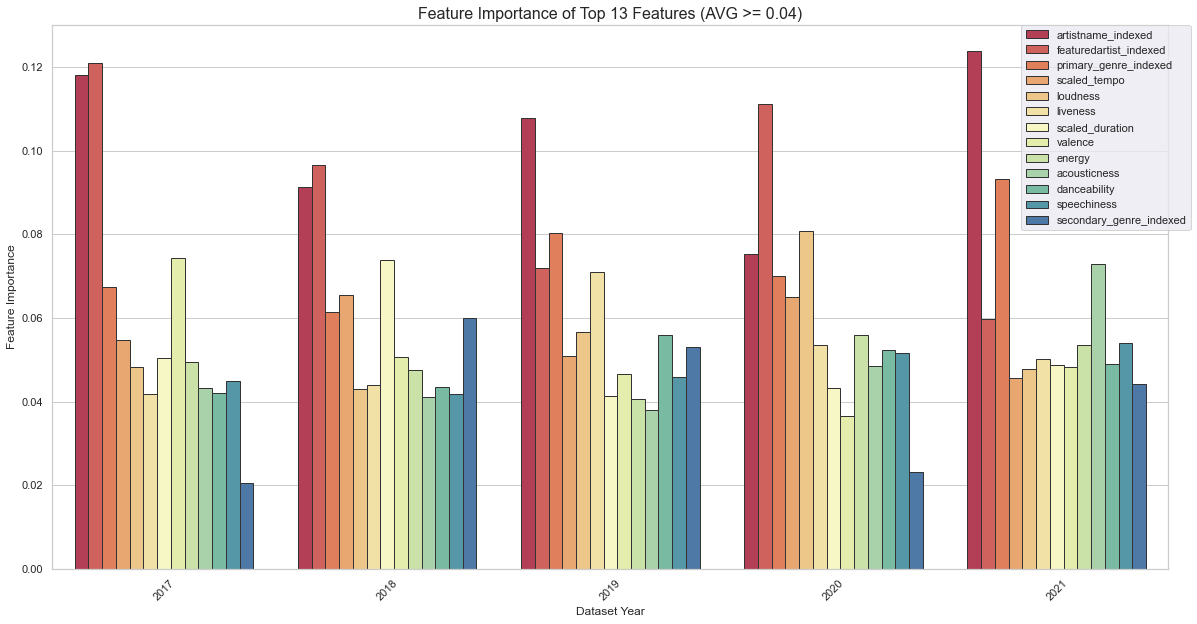

In [37]:
# Visualization of Top 13 Feature Importances - Year over Year

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

feature_keep = df[df['SUM']>=0.2].melt(id_vars='Feature')
feature_keep = feature_keep[feature_keep['variable']!='SUM']

# Seaborn Style
sns.set(style='whitegrid')

# Grouped Bar Chart
ax = sns.barplot(x='variable', y='value', hue='Feature', data=feature_keep, palette='Spectral', edgecolor='0.2') 

sns.set(rc={"figure.figsize":(20, 10)})

# Add Chart Title
plt.title('Feature Importance of Top 13 Features (AVG >= 0.04)', fontsize=16)

# Axis Titles
plt.xlabel('Dataset Year')
plt.ylabel('Feature Importance')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper right', borderaxespad=0)

# Rotate Axis Labels
plt.xticks(rotation=45)

### Deep Learning Approach: Binary Classification via Neural Network Perceptron (Numerical Features Only)
As referenced above, to put into practice our teachings on Deep Learning from the IBM Advanced Data Science Specialization, I defined, trained, and evaluated 5 separate Neural Network Binary Classification Perceptron models using the 2017, 2018, 2019, 2020, and 2021 datasets. Using the Feature Importance findings from the Random Forest models above, I removed the bottom 16 features (highlighted in yellow in the table above).

Because the remaining categorical features (primary artist, featured artist, primary genre, secondary genre) were all high-cardinality features, I also opted to leave those features out for this particular exercise. This is because One-Hot Encoding those particular features would be incredibly inefficient due to the number of dummy variables it would create. Thus the final set of features used to train the NN models was as follows: energy, danceability, loudness, speechiness, acousticness, liveness, valence, tempo, and duration.

In the "Conclusion + Next Steps" section below, I detail an approach that I would like to take in future iterations of this project to incorporate these high-cardinality categorical features into the Deep Learning approach as well.

The performance metrics of the 5 NN Perceptron Models (AUC) can be observed below (**no overfitting**):
<br>**2017 Train:** 86.2%
<br>**2017 Test:** 85.4%
<br>**2018 Train:** 83.3%
<br>**2018 Test:** 83.0%
<br>**2019 Train:** 83.3%
<br>**2019 Test:** 82.7%
<br>**2020 Train:** 82.0%
<br>**2020 Test:** 81.1%
<br>**2021 Train:** 84.8%
<br>**2021 Test:** 83.4%

We see that the NN Perceptron approach produced performance numbers quite in line with the Random Forest approach. As mentioned above, in the "Conclusion + Next Steps" section below, I will detail the next steps that I would like to take in future iterations of this project to push the performance of my NN models further.

In [9]:
# Setup and Installs - TensorFlow

!pip install tensorflow
import tensorflow as tf
print(tf.__version__)

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 3.8 MB 18.2 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 5.1 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 2.4 MB/s  eta 0:00:01
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.35.0
    Uninstalling grpcio-1.35.0:
      Successfully uninstalled grpcio-1.35.0
  Attempting uninstall: opt-einsum
    Found existing installation: opt-einsum 3.1.0
    Uninstalling opt-einsum-3.1.0:
      Successfully uninstalled opt-einsum-3.1.0
  Attempting unins

#### Neural Network Components:
**Loss Function:** Categorical Cross-Entropy
<br>**Optimizer:** Adam
<br>**Metric:** Area Under ROC
<br>**Number of Dropouts:** 2
<br>**Number of Input Dimensions:** 9
<br>**Hidden Layer Activation Function:** ReLU
<br>**Output Layer Activation Function:** Sigmoid

In [3]:
# Imports

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Define Seed
seed = 4434
np.random.seed(seed)

# Label Choice
labelchoice = 'binary_performance_bin'

# Select Feature and Labels
nnselect1 = df_data_1[['energy','danceability','loudness','speechiness','acousticness','liveness','valence','tempo','duration_ms',labelchoice]]
nnselect2 = df_data_2[['energy','danceability','loudness','speechiness','acousticness','liveness','valence','tempo','duration_ms',labelchoice]]
nnselect3 = df_data_3[['energy','danceability','loudness','speechiness','acousticness','liveness','valence','tempo','duration_ms',labelchoice]]
nnselect4 = df_data_4[['energy','danceability','loudness','speechiness','acousticness','liveness','valence','tempo','duration_ms',labelchoice]]
nnselect5 = df_data_5[['energy','danceability','loudness','speechiness','acousticness','liveness','valence','tempo','duration_ms',labelchoice]]

# Separate Features from Labels

x1 = nnselect1.drop(labelchoice, axis = 1)
y1 = nnselect1[labelchoice]

x2 = nnselect2.drop(labelchoice, axis = 1)
y2 = nnselect2[labelchoice]

x3 = nnselect3.drop(labelchoice, axis = 1)
y3 = nnselect3[labelchoice]

x4 = nnselect4.drop(labelchoice, axis = 1)
y4 = nnselect4[labelchoice]

x5 = nnselect5.drop(labelchoice, axis = 1)
y5 = nnselect5[labelchoice]

# Scaling Features

sc1 = preprocessing.StandardScaler()
sc2 = preprocessing.StandardScaler()
sc3 = preprocessing.StandardScaler()
sc4 = preprocessing.StandardScaler()
sc5 = preprocessing.StandardScaler()

x1 = pd.DataFrame(sc1.fit_transform(x1))
x2 = pd.DataFrame(sc2.fit_transform(x2))
x3 = pd.DataFrame(sc3.fit_transform(x3))
x4 = pd.DataFrame(sc4.fit_transform(x4))
x5 = pd.DataFrame(sc5.fit_transform(x5))

# Processing Labels

num_classes1 = y1.unique().size
num_classes2 = y2.unique().size
num_classes3 = y3.unique().size
num_classes4 = y4.unique().size
num_classes5 = y5.unique().size

le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
le3 = preprocessing.LabelEncoder()
le4 = preprocessing.LabelEncoder()
le5 = preprocessing.LabelEncoder()

le1.fit(y1)
y1_le = le1.transform(y1)
y1_ohe = to_categorical(y1_le)

le2.fit(y2)
y2_le = le2.transform(y2)
y2_ohe = to_categorical(y2_le)

le3.fit(y3)
y3_le = le3.transform(y3)
y3_ohe = to_categorical(y3_le)

le4.fit(y4)
y4_le = le4.transform(y4)
y4_ohe = to_categorical(y4_le)

le5.fit(y5)
y5_le = le5.transform(y5)
y5_ohe = to_categorical(y5_le)

# TRAIN, TEST, SPLIT
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1.values,y1_ohe, test_size=0.2)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2.values,y2_ohe, test_size=0.2)
x_train3, x_test3, y_train3, y_test3 = train_test_split(x3.values,y3_ohe, test_size=0.2)
x_train4, x_test4, y_train4, y_test4 = train_test_split(x4.values,y4_ohe, test_size=0.2)
x_train5, x_test5, y_train5, y_test5 = train_test_split(x5.values,y5_ohe, test_size=0.2)

# Neural Network Structures

model1 = Sequential()  # Instantiate Sequential Model
model1.add(Dense(18, input_dim=9, activation='relu')) # Input Layer
model1.add(Dense(36, activation='relu')) # 1st Dense Layer
model1.add(Dropout(0.1)) # 1st Dropout for Regularization
model1.add(Dense(72, activation='relu')) # 2nd Dense Layer
model1.add(Dropout(0.2)) # 2nd Dropout for Regularization
model1.add(Dense(num_classes1, activation='sigmoid')) # Binary Output via Sigmoid Activation Function
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC']) # Define Loss Function, Optimizer, Metric
    
model2 = Sequential()  # Instantiate Sequential Model
model2.add(Dense(18, input_dim=9, activation='relu')) # Input Layer
model2.add(Dense(36, activation='relu')) # 1st Dense Layer
model2.add(Dropout(0.1)) # 1st Dropout for Regularization
model2.add(Dense(72, activation='relu')) # 2nd Dense Layer
model2.add(Dropout(0.2)) # 2nd Dropout for Regularization
model2.add(Dense(num_classes2, activation='sigmoid')) # Binary Output via Sigmoid Activation Function
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC']) # Define Loss Function, Optimizer, Metric

model3 = Sequential()  # Instantiate Sequential Model
model3.add(Dense(18, input_dim=9, activation='relu')) # Input Layer
model3.add(Dense(36, activation='relu')) # 1st Dense Layer
model3.add(Dropout(0.1)) # 1st Dropout for Regularization
model3.add(Dense(72, activation='relu')) # 2nd Dense Layer
model3.add(Dropout(0.2)) # 2nd Dropout for Regularization
model3.add(Dense(num_classes1, activation='sigmoid')) # Binary Output via Sigmoid Activation Function
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC']) # Define Loss Function, Optimizer, Metric

model4 = Sequential()  # Instantiate Sequential Model
model4.add(Dense(18, input_dim=9, activation='relu')) # Input Layer
model4.add(Dense(36, activation='relu')) # 1st Dense Layer
model4.add(Dropout(0.1)) # 1st Dropout for Regularization
model4.add(Dense(72, activation='relu')) # 2nd Dense Layer
model4.add(Dropout(0.2)) # 2nd Dropout for Regularization
model4.add(Dense(num_classes4, activation='sigmoid')) # Binary Output via Sigmoid Activation Function
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC']) # Define Loss Function, Optimizer, Metric

model5 = Sequential()  # Instantiate Sequential Model
model5.add(Dense(18, input_dim=9, activation='relu')) # Input Layer
model5.add(Dense(36, activation='relu')) # 1st Dense Layer
model5.add(Dropout(0.1)) # 1st Dropout for Regularization
model5.add(Dense(72, activation='relu')) # 2nd Dense Layer
model5.add(Dropout(0.2)) # 2nd Dropout for Regularization
model5.add(Dense(num_classes5, activation='sigmoid')) # Binary Output via Sigmoid Activation Function
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC']) # Define Loss Function, Optimizer, Metric
    
# Evaluating 2017 Model on Test Set

model1.fit(x_train1,y_train1,epochs=10,verbose=1)
score = model1.evaluate(x_test1,y_test1)
score[1]

Epoch 1/10
1095/1095 [==============================] - 2s 1ms/step - loss: 0.6622 - auc: 0.6234
Epoch 2/10
1095/1095 [==============================] - 1s 1ms/step - loss: 0.5989 - auc: 0.7349
Epoch 3/10
1095/1095 [==============================] - 1s 1ms/step - loss: 0.5667 - auc: 0.7736
Epoch 4/10
1095/1095 [==============================] - 1s 1ms/step - loss: 0.5373 - auc: 0.8014
Epoch 5/10
1095/1095 [==============================] - 1s 1ms/step - loss: 0.5249 - auc: 0.8116
Epoch 6/10
1095/1095 [==============================] - 1s 1ms/step - loss: 0.5127 - auc: 0.8219
Epoch 7/10
1095/1095 [==============================] - 1s 1ms/step - loss: 0.5078 - auc: 0.8252
Epoch 8/10
1095/1095 [==============================] - 1s 1ms/step - loss: 0.4986 - auc: 0.8330
Epoch 9/10
1095/1095 [==============================] - 1s 1ms/step - loss: 0.4949 - auc: 0.8362
Epoch 10/10
274/274 [==============================] - 0s 786us/step - loss: 0.4704 - auc: 0.8545


0.8544936180114746

In [4]:
# Evaluating 2017 Model on Training Set

score = model1.evaluate(x_train1,y_train1)
score[1]

1095/1095 [==============================] - 1s 916us/step - loss: 0.4591 - auc: 0.8623


0.8622719049453735

#### 2018 Model

In [5]:
# Evaluating 2018 Model on Test Set

model2.fit(x_train2,y_train2,epochs=10,verbose=1)
score = model2.evaluate(x_test2,y_test2)
score[1]

Epoch 1/10
1064/1064 [==============================] - 2s 1ms/step - loss: 0.6598 - auc: 0.6290
Epoch 2/10
1064/1064 [==============================] - 1s 1ms/step - loss: 0.6017 - auc: 0.7258
Epoch 3/10
1064/1064 [==============================] - 1s 1ms/step - loss: 0.5745 - auc: 0.7590
Epoch 4/10
1064/1064 [==============================] - 1s 1ms/step - loss: 0.5606 - auc: 0.7751
Epoch 5/10
1064/1064 [==============================] - 1s 1ms/step - loss: 0.5486 - auc: 0.7869
Epoch 6/10
1064/1064 [==============================] - 1s 1ms/step - loss: 0.5396 - auc: 0.7958
Epoch 7/10
1064/1064 [==============================] - 1s 1ms/step - loss: 0.5353 - auc: 0.7999
Epoch 8/10
1064/1064 [==============================] - 1s 1ms/step - loss: 0.5314 - auc: 0.8028
Epoch 9/10
1064/1064 [==============================] - 1s 1ms/step - loss: 0.5266 - auc: 0.8061
Epoch 10/10
266/266 [==============================] - 0s 839us/step - loss: 0.5021 - auc: 0.8302


0.8302419185638428

In [6]:
# Evaluating 2018 Model on Training Set

score = model2.evaluate(x_train2,y_train2)
score[1]

1064/1064 [==============================] - 1s 873us/step - loss: 0.4982 - auc: 0.8331


0.8331300020217896

#### 2019 Model

In [7]:
# Evaluating 2019 Model on Test Set

model3.fit(x_train3,y_train3,epochs=10,verbose=1)
score = model3.evaluate(x_test3,y_test3)
score[1]

Epoch 1/10
982/982 [==============================] - 2s 1ms/step - loss: 0.6602 - auc: 0.6318
Epoch 2/10
982/982 [==============================] - 1s 1ms/step - loss: 0.6092 - auc: 0.7174
Epoch 3/10
982/982 [==============================] - 1s 1ms/step - loss: 0.5830 - auc: 0.7505
Epoch 4/10
982/982 [==============================] - 1s 1ms/step - loss: 0.5584 - auc: 0.7775A: 1s - loss: 
Epoch 5/10
982/982 [==============================] - 1s 1ms/step - loss: 0.5500 - auc: 0.7849
Epoch 6/10
982/982 [==============================] - 1s 1ms/step - loss: 0.5409 - auc: 0.7935
Epoch 7/10
982/982 [==============================] - 1s 1ms/step - loss: 0.5356 - auc: 0.7975
Epoch 8/10
982/982 [==============================] - 1s 1ms/step - loss: 0.5267 - auc: 0.8061
Epoch 9/10
982/982 [==============================] - 1s 1ms/step - loss: 0.5280 - auc: 0.8047
Epoch 10/10
246/246 [==============================] - 0s 867us/step - loss: 0.5044 - auc: 0.8270


0.8270381093025208

In [8]:
# Evaluating 2019 Model on Training Set

score = model3.evaluate(x_train3,y_train3)
score[1]

982/982 [==============================] - 1s 973us/step - loss: 0.4963 - auc: 0.8332


0.8332493305206299

#### 2020 Model

In [9]:
# Evaluating 2020 Model on Test Set

model4.fit(x_train4,y_train4,epochs=10,verbose=1)
score = model4.evaluate(x_test4,y_test4)
score[1]

Epoch 1/10
908/908 [==============================] - 2s 1ms/step - loss: 0.6667 - auc: 0.6229
Epoch 2/10
908/908 [==============================] - 1s 1ms/step - loss: 0.6321 - auc: 0.6902
Epoch 3/10
908/908 [==============================] - 1s 1ms/step - loss: 0.6007 - auc: 0.7341
Epoch 4/10
908/908 [==============================] - 1s 1ms/step - loss: 0.5824 - auc: 0.7565
Epoch 5/10
908/908 [==============================] - 1s 1ms/step - loss: 0.5685 - auc: 0.7706
Epoch 6/10
908/908 [==============================] - 1s 1ms/step - loss: 0.5600 - auc: 0.7797
Epoch 7/10
908/908 [==============================] - 1s 1ms/step - loss: 0.5577 - auc: 0.7789
Epoch 8/10
908/908 [==============================] - 1s 1ms/step - loss: 0.5524 - auc: 0.7855
Epoch 9/10
908/908 [==============================] - 1s 1ms/step - loss: 0.5523 - auc: 0.7879
Epoch 10/10
227/227 [==============================] - 0s 889us/step - loss: 0.5246 - auc: 0.8111


0.8111111521720886

In [10]:
# Evaluating 2020 Model on Training Set

score = model4.evaluate(x_train4,y_train4)
score[1]

908/908 [==============================] - 1s 864us/step - loss: 0.5160 - auc: 0.8204


0.8203873634338379

#### 2021 Model

In [11]:
# Evaluating 2021 Model on Test Set

model5.fit(x_train5,y_train5,epochs=10,verbose=1)
score = model5.evaluate(x_test5,y_test5)
score[1]

Epoch 1/10
776/776 [==============================] - 1s 1ms/step - loss: 0.6546 - auc: 0.6293
Epoch 2/10
776/776 [==============================] - 1s 1ms/step - loss: 0.5971 - auc: 0.7328
Epoch 3/10
776/776 [==============================] - 1s 1ms/step - loss: 0.5737 - auc: 0.7610
Epoch 4/10
776/776 [==============================] - 1s 1ms/step - loss: 0.5545 - auc: 0.7815
Epoch 5/10
776/776 [==============================] - 1s 1ms/step - loss: 0.5445 - auc: 0.7916
Epoch 6/10
776/776 [==============================] - 1s 1ms/step - loss: 0.5304 - auc: 0.8051
Epoch 7/10
776/776 [==============================] - 1s 1ms/step - loss: 0.5235 - auc: 0.8103
Epoch 8/10
776/776 [==============================] - 1s 1ms/step - loss: 0.5174 - auc: 0.8169
Epoch 9/10
776/776 [==============================] - 1s 1ms/step - loss: 0.5098 - auc: 0.8225
Epoch 10/10
194/194 [==============================] - 0s 849us/step - loss: 0.4966 - auc: 0.8342


0.8341846466064453

In [12]:
# Evaluating 2021 Model on Training Set

score = model5.evaluate(x_train5,y_train5)
score[1]

776/776 [==============================] - 1s 863us/step - loss: 0.4796 - auc: 0.8476


0.8475856781005859

### Visualization of Model Training and Evaluation Performance (AUC)
The following visualization shows an overall picture of the performance of each model on each dataset. It includes the intial SVM Baseline Models, Final RF 70-30 Models, NN Perceptron Models, and also the Tuned RF Proof of Concept.

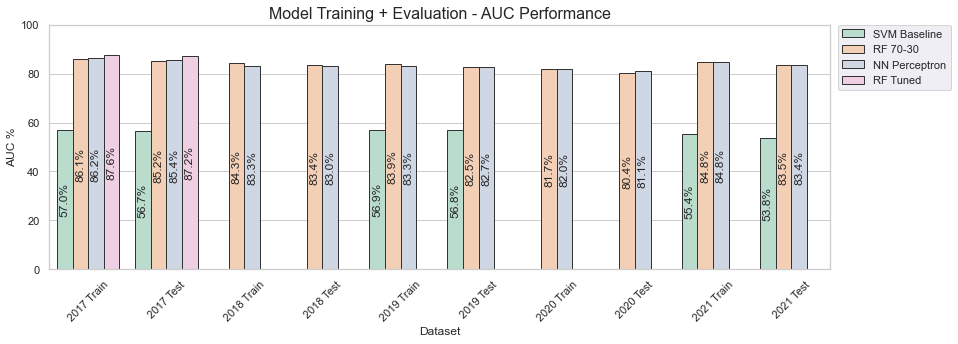

In [3]:
# Visualization of Model Training and Evaluation Performance

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dfvis = pd.DataFrame({'Dataset': ['2017 Train','2017 Test','2017 Train','2017 Test','2017 Train','2017 Test','2017 Train','2017 Test','2018 Train','2018 Test','2018 Train','2018 Test','2019 Train','2019 Test','2019 Train','2019 Test','2019 Train','2019 Test','2020 Train','2020 Test','2020 Train','2020 Test','2021 Train','2021 Test','2021 Train','2021 Test','2021 Train','2021 Test'],
                   'Model': ['SVM Baseline','SVM Baseline','RF 70-30','RF 70-30','NN Perceptron','NN Perceptron','RF Tuned','RF Tuned','RF 70-30','RF 70-30','NN Perceptron','NN Perceptron','RF 70-30','RF 70-30','NN Perceptron','NN Perceptron','SVM Baseline','SVM Baseline','RF 70-30','RF 70-30','NN Perceptron','NN Perceptron','SVM Baseline','SVM Baseline','RF 70-30','RF 70-30','NN Perceptron','NN Perceptron'],
                   'Score': [57.0,56.7,86.1,85.2,86.2,85.4,87.6,87.2,84.3,83.4,83.3,83.0,83.9,82.5,83.3,82.7,56.9,56.8,81.7,80.4,82.0,81.1,55.4,53.8,84.8,83.5,84.8,83.4],
                   })
# Seaborn Style
sns.set(style='whitegrid')

# Grouped Bar Chart
ax = sns.barplot(x='Dataset', y='Score', hue='Model', data=dfvis, palette='Pastel2', edgecolor='0.2') 

sns.set(rc={"figure.figsize":(14, 4.5)})

# Add Chart Title
plt.title('Model Training + Evaluation - AUC Performance', fontsize=16)

# Axis Titles
plt.xlabel('Dataset')
plt.ylabel('AUC %')
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

# Rotate Axis Labels
plt.xticks(rotation=45)

# Bar Labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%',label_type='center',rotation=90)

### Conclusion + Next Steps
In conclusion, we saw that both the final Random Forest models and the final NN Perceptron models achieved AUC performance metrics above the goal threshold of 80%. As with any project, there are always things that could be improved upon for future iterations, and I've listed the approaches that I would like to take for my future iterations of this project below:
* 1) Firstly, I would like to re-factor my code for the Random Forest models and Hyperparameter Tuning so that they are functional on Python 3.9+ without compatability errors. This would allow me to spin up powerful parallelized environments on IBM Watson Studio to execute my code.
* 2) Secondly, once my code is compatible with Python 3.9+, I would like to incorporate the Feature Selection that I had identified above. I.e. down-selecting to include only the following features: primary artist, featured artist, primary genre, secondary genre, energy, danceability, loudness, speechiness, acousticness, liveness, valence, tempo, and duration. This would allow me to remove the noise that comes with the "less important" features, while maintaining SparkML's Random Forest Implementation's powerful ability to handle High-Cardinality Categorical Features. I anticipate these changes will bring further performance increases.
* 3) Thirdly, I would like to incorporate the High-Cardinality Categorical Features into the NN Perceptron Models via clever use of Embedding Layers. Embedding would allow these High-Cardinality Categorical Features to be encoded into a relatively smaller dimensional space (compared to One-Hot Encoding). This would make it much more effective and efficient to incorporate these features, and it would further increase performance by unlocking the predictive power of these features.

**Looking back, this capstone project was an incredible learning journey for me to put into practice the learnings from the IBM Advanced Data Science Specialization. I am very proud of the problems that I was able to solve along the way, and the expertise that I was able to hone during the process. Thank you so much IBM Team for such a great experience and course! - Krishan Deo**